> python3 $SUMO_HOME/tools/visualization/plot_summary.py -i basic_output.xml --xlim 0,1000 -o summary_basic.png -m stopped


# Simulation setup

In [1]:
import os, sys
import numpy as np
import traci

In [2]:
gui = True #to run either sumo or sumo-gui
SUMO_HOME = os.environ["SUMO_HOME"] #locating the simulator
default_scenario = "./basic_simulation.sumocfg"

sys.path.append(SUMO_HOME+"/tools")
import sumolib

In [3]:
def run_simulation(gui_needed: bool, scenario: str):
    '''Runs a SUMO simulation.
        -----------------------
        parameters:
        - gui-needed: if true SUMO is started with GUI
        - scenario: path to the .sumocfg file to run'''
    
    sumo_binary = "sumo-gui" if gui_needed else "sumo"
    sumo_cmd = [sumo_binary, "-c", scenario]
    #starting SUMO server:
    traci.start(sumo_cmd)
    
    #conducting the simulation:
    step = 0
    while step < 600:
        step += 1
        traci.simulationStep()
    
    traci.close()

In [4]:
run_simulation(True, default_scenario)

 Retrying in 1 seconds


# Parsing and plotting outputs

In [51]:
output_file = "outputs/with_auctions.xml"

In [48]:
def get_stopped_vehicles_from_output(output_file: str):
    '''Extracts number of stopped vehicles from a simulation summary output.
        ------------------------
        parameters:
        - output_file: the simulation output to parse
        
        Returns: time and #stopped vehicle pairs'''
    
    t, v = [], [] #(time x value) pairs
    for time, val in sumolib.xml.parse_fast(output_file, "step", ("time", "stopped")):
        t.append(sumolib.miscutils.parseTime(time))
        v.append(float(val))
    return t,v

In [59]:
import matplotlib.pyplot as plt

def plot_stopped_vehicles(time_values, stopped_values, titles):
    fig, ax = plt.subplots()
    for i in range(len(time_values)):
        #ax.plot(time_values[i], np.array(stopped_values[i])/max(stopped_values[i])*100, label=titles[i])
        ax.plot(time_values[i], np.array(stopped_values[i]), label=titles[i])
    ax.set_xlabel("timestep")
    ax.set_ylabel("% of stopped vehicles")
    ax.set_title("Number of stopped vehicles")
    ax.legend()
    return fig, ax

(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:title={'center':'Number of stopped vehicles'}, xlabel='timestep', ylabel='% of stopped vehicles'>)

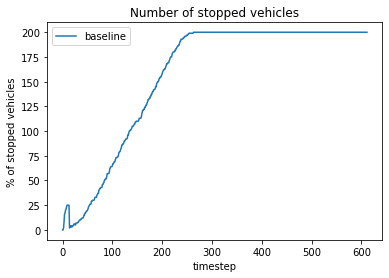

In [60]:
t,v = get_stopped_vehicles_from_output(output_file)
plot_stopped_vehicles([t], [v], ["baseline"])

# Processing routes

We have to collect the routes that the vehicles actually use during the original simulation.

In [5]:
def read_movements(filename: str) -> list:
    '''Reads the given route file and returns the edges of the routes'''
    
    movements = []
    
    for vehicle in sumolib.xml.parse(filename, "vehicle"):
        route = vehicle.route[0] # access the first (and only) child element with name 'route'
        edges = route.edges.split()
        '''i = 0
        mov_ = []
        parking = vehicle.stop[0].parkingArea.split("pl")[-1]
        while i<len(edges) and edges[i] != parking:
            mov_.append(edges[i])
            i += 1
        if i==0 and edges[0] == parking:
            mov_.append(edges[0])'''
        movements.append(edges)
        
    return movements

In [6]:
movements = read_movements("scenario/parking_routes.rou.xml")

# Instructed simulation

We have to achieve the following via TraCI:
1. make vehicles complete their routes (collected previously), controlled by the rerouter device
2. then go to a parking lot

In [7]:
traci.start(["sumo-gui", "-c", "auction_simulation.sumocfg"])

traci.route.add("route0", movements[0])
vehicle = traci.vehicle.add("veh0", "route0", typeID="reroutingType")

step = 0
while step < 500:
    step += 1
    traci.simulationStep()
    #if traci.vehicle.isStopped("veh0"):
    try:
        route_idx = traci.vehicle.getRouteIndex("veh0")
        route = traci.vehicle.getRoute("veh0")
        if route_idx == len(route)-1:
            #traci.vehicle.setR
            #traci.route.add("route_to_pl344_0", edges=["344"])
            #traci.vehicle.add
            traci.vehicle.changeTarget("veh0", "344")
            traci.vehicle.setParkingAreaStop("veh0", "pl344", duration=86400)
            #traci.vehicle.rerouteParkingArea("veh0", "pl344", duration=86400)
    except:
        pass
        #traci.vehicle.setParkingAreaStop("veh0", "pl344", duration=86400)

traci.close()

 Retrying in 1 seconds
Could not connect to TraCI server at localhost:53925 [Errno 111] Connection refused
 Retrying in 1 seconds


# Connecting to the Auction method

In [7]:
def get_distance_to_parkings(traci, vehicle_id: str, sumo_parkings_lane_id: list) -> np.array:
    '''Collecting distances of parking lots for each vehicles'''
    distances = []
    for p in sumo_parkings_lane_id:
        distances.append(traci.simulation.getDistanceRoad(
            traci.vehicle.getRoadID(vehicle_id), 0, p, 0))
    return distances

### Reading parking lot capacities:

In [8]:
import xml.etree.ElementTree as ET

def read_pl_capacities(filename: str) -> (list,list):
    '''Reads an additional file that contains parking lot definitions. Returns the parking lot ids and the corresp. capacities'''
    tree = ET.parse(filename)
    root = tree.getroot()
    p_ids = []
    p_capacities = []
    for parea in root:
        p_ids.append(parea.attrib["id"])
        p_capacities.append(parea.attrib["roadsideCapacity"])
    return p_ids, p_capacities

In [9]:
import auction

def init_auction_method(parking_capacities, vehicle_ids, starting_prices, preference_function, bid_step = 10, max_price = 1000)-> (list, list):
    """Initializes the participants of the auction method
       -------------
       parameters:
           - parking_capacities: capacity values of the parking lots (number of auctions),
           - vehicle_ids: IDs of vehicles (buyers),
           - starting_prices: list of starting prices of the auctions,
           - preference_function: the function that calculates which parking lot is preferred.
                                   signature: preference_function(buyer_object, current_price_list),
           - bid_step: amount of money by which current bids will be increased during auctions,
           - max_price: maximum price that the buyers are willing to accept"""
    
    auctions = []
    buyers = []
    
    for pcap in parking_capacities:
        for i in range(pcap):
            auctions.append(auction.Auctioneer(starting_prices[len(auctions)], bid_step, "auc%d"%i))
            
    buyers = [auction.Buyer(auctions, max_price, preference_function, buyer_id=vehicle_ids[i]) for i in range(len(vehicle_ids))]
    return auctions, buyers

In [22]:
def min_price(buyer_id, auction_ids, bids):
    """Computes preferences based only on current bids."""
    return np.argmin(bids)

class MinDistancePreference:
    """Computes preferences based on distance to a particular parking lot.
       It results in prefering the closest parking alternative against more distant ones."""
    def __init__(self, distance_mtx, parking_capacities):
        self.distance_mtx = {}
        for x in distance_mtx:
            distances = []
            for i in range(len(parking_capacities)):
                for j in range(parking_capacities[i]):
                    distances.append(distance_mtx[x][i])
            self.distance_mtx[x] = distances
            
        self.parking_ranges = []
        last = 0
        for caps in parking_capacities:
            for i in range(caps):
                self.parking_ranges.append(last+caps)
            last = last+caps
            
            
    def __call__(self, buyer_id, auction_ids, bids):
        distance_vector = np.array(self.distance_mtx[buyer_id])
        active_indices = [int(auc_id.split("auc")[-1]) for auc_id in auction_ids]
        distance_vector = distance_vector[active_indices]
        return np.argmin(distance_vector)
        
        
class BalancedCostDistancePreference(MinDistancePreference):
    """Computes preferences based on 0.5*cost+0.5*distance function.
       That results in prefering closer and cheaper parking against the more expensive and more distant ones.
       (Values gets normalized during calculation.)"""
    def __call__(self, buyer_id, auction_ids, bids):
        distance_vector = np.array(self.distance_mtx[buyer_id])
        active_indices = [int(auc_id.split("auc")[-1]) for auc_id in auction_ids]
        distance_vector = distance_vector[active_indices]
        #normalizing into range [0,1]:
        bids = np.array(bids) / max(bids)
        distance_vector = distance_vector / max(distance_vector)
        return np.argmin(bids + distance_vector)
    
class IndividualPreference:
    """Calculates preferences based on a preliminary calculated preference list.
        This may symbolize that one has favorite parking lots."""
    def __init__(self, buyer_ids, auction_count):
        self.preference_lists = {}
        for buyer in buyer_ids:
            self.preference_lists[buyer] = np.random.permutation(auction_count)
            
    def __call__(self, buyer_id, auction_ids, bids):
        pref_vector = self.preference_lists[buyer_id]
        active_indices = [int(auc_id.split("auc")[-1]) for auc_id in auction_ids]
        pref_vector = pref_vector[active_indices]
        return np.min(pref_vector)

In [11]:
def init_simulation(traci_commands: list, movements: list, parking_lot_file: str):
    '''Initializes the simulation, and returns the final distances
       ----------------
       parameters:
        - traci_commands: commands to start TraCI with,
        - movements: list of the edges simulated vehicles shall go through,
        - parking_lot_file: path to the file defining parkingAreas
        
       returns:
        the distances between vehicles and parking lots, parking lot ids, parking lot capacities, vehicle ids'''
    traci.start(traci_commands)
    
    dep_num = 0
    #for i in range(len(movements)):
    #    traci.route.add("route%d" % i, movements[i])
    #    traci.vehicle.add("veh%d" % i, "route%d" % i, typeID="reroutingType")
    
    while dep_num < len(movements):
        traci.simulationStep()
        dep_num += traci.simulation.getDepartedNumber()
    
    p_ids, p_caps = read_pl_capacities(parking_lot_file)
    distances = {}
    p_edges = [p_id.split("pl")[-1] for p_id in p_ids]
    veh_ids = traci.vehicle.getIDList()
    for id_ in veh_ids:
        distances[id_] = get_distance_to_parkings(traci, id_, p_edges)
    
    return distances, p_ids, p_caps, veh_ids

In [12]:
def simulate_after_auction(traci, parking_mapping, max_step = 600):
    step = 1
    while step < max_step:
        
        step += 1
        traci.simulationStep()
        
        '''for i in range(len(movements)):
            new_veh = "veh%d"%i
            if not(new_veh) in vehicles_added:
                try:
                    vehicle = traci.vehicle.add("veh%d" % i, "route%d" % i, typeID="reroutingType")
                    vehicle_added.add(new_veh)
                except:
                    pass'''
                
        veh_list = traci.vehicle.getIDList()
        for v in veh_list:
            try:
                traci.vehicle.changeTarget(v, parking_mapping[v].split("pl")[-1])
                traci.vehicle.setParkingAreaStop(v, parking_mapping[v], duration=86400)
            except:
                pass

# Auctions and simulation

In [37]:
#sumo_cmd = ["sumo-gui", "-c", "auction_simulation.sumocfg"]
sumo_cmd = ["sumo", "-c", "auction_simulation.sumocfg", "--summary-output", "outputs/price_preference.xml"]
distance_mtx, parking_ids, parking_capacities, veh_ids = init_simulation(sumo_cmd, movements, "scenario/parkings.add.xml")
parking_capacities = [int(pc) for pc in parking_capacities]

 Retrying in 1 seconds


In [32]:
from importlib import reload
reload(auction)

<module 'auction' from '/home/levente/Egyetem/PhD/2_felev/bprof_mi/multiagent_lab/auction.py'>

In [38]:
min_dist_pref = MinDistancePreference(distance_mtx, parking_capacities)
opt_pref = OptimalCostPreference(distance_mtx, parking_capacities)
indiv_pref = IndividualPreference(veh_ids, np.sum(parking_capacities))
auctions, buyers = init_auction_method(parking_capacities, veh_ids, np.random.normal(300, 25, np.sum(parking_capacities)), min_price)#min_price)

In [39]:
auction_result = auction.run_auctions(auctions, buyers, verbose=True)

18 auctions are won from 228
23 auctions are won from 210
24 auctions are won from 187
29 auctions are won from 163
27 auctions are won from 134
26 auctions are won from 107
23 auctions are won from 81
24 auctions are won from 58
6 auctions are won from 34


In [27]:
def map_auction_to_parking_area(auction_id, parking_capacities, parking_ids):
    i, tot = 0, 0
    auction_index = int(auction_id.split("auc")[-1])
    if auction_index == 0:
        return parking_ids[0]
    while tot != auction_index:
        if parking_capacities[i]+tot >= auction_index:
            return parking_ids[i]
        else:
            tot += parking_capacities[i]
            i += 1
            
def create_auction_result_maps(auction_results, buyers, parking_capacities, parking_ids):
    result_map = {}
    for i, auc in enumerate(auction_results):
        p_area = map_auction_to_parking_area(auc["auction_id"], parking_capacities, parking_ids)
        result_map[auc["buyer_id"]] = p_area
    return result_map

In [40]:
parking_mapping = create_auction_result_maps(auction_result, buyers, parking_capacities, parking_ids)

In [41]:
simulate_after_auction(traci, parking_mapping)
traci.close()

(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:title={'center':'Number of stopped vehicles'}, xlabel='timestep', ylabel='% of stopped vehicles'>)

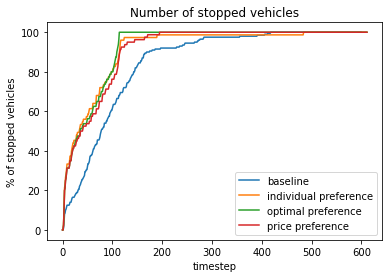

In [44]:
traditional_file = "outputs/basic_output.xml"
indiv_file = "outputs/indiv_preference.xml"
opt_file = "outputs/opt_preference.xml"
price_file = "outputs/price_preference.xml"

t_t, v_t = get_stopped_vehicles_from_output(traditional_file)
t_a_i, v_a_i = get_stopped_vehicles_from_output(indiv_file)
t_a_o, v_a_o = get_stopped_vehicles_from_output(opt_file)
t_a_p, v_a_p = get_stopped_vehicles_from_output(price_file)

plot_stopped_vehicles([t_t, t_a_i, t_a_o, t_a_p],
                      [v_t, v_a_i, v_a_o, v_a_p],
                      ["baseline", "individual preference", "optimal preference", "price preference"])